In [22]:
import torch

In [23]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"] 

In [24]:
import utils.transformer as transformer

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)


model = transformer.GPTModel(GPT_CONFIG_124M)

model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_skip_layer): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_fea

In [25]:
with torch.no_grad():
    logits = model(inputs)

probablity = torch.softmax(logits, dim=-1)

print(probablity.shape)





torch.Size([2, 3, 50257])


In [26]:
token_ids = torch.argmax(probablity, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [27]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

tokenizer = tiktoken.get_encoding("gpt2")


In [28]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [29]:
## So as model isn't trained, we can see the output is random
# let's check what is the targer probaily i.e. probability of the target token

target_prob = probablity[0, torch.arange(token_ids.shape[1]), targets[0]]
print(f"Target token probabilities: {target_prob}")


Target token probabilities: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [30]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [31]:
# logits is of shape (batch_size * context_length, vocab_size)
# targets is of shape (batch_size * context_length)
# and target contains the index of the target token in the vocabulary
# so cross entropy loss will first get the logits from the logits_flat for the targets_flat
# indicers , softmax the logits and then take the values of the targets_flat indicers
# and then compute the mean of the loss and finally negate it

## we negate the log avg probabilty as log in 0 to 1 is lowest when x=0 and higert when x=1(y=0)
# so we negate it to make it lowest when x=1 and highest when x=0
# and hence we will have a loss function 
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [32]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


In [33]:
with open("the-verdict.txt", "r") as f:
    text_data = f.read()

print(text_data[:1000])


I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--even through th

In [34]:
total_characters = len(text_data)
print(f"Total characters: {total_characters}")

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = tokenizer.encode(text_data)
print(f"Total tokens: {len(token_ids)}")

Total characters: 20479
Total tokens: 5145


In [35]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length,stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text, allowed_special={'<|endoftext|>'})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i+1:i+max_length+1] 

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    

def create_dataloader_v1(text,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text, tokenizer, max_length, stride)

    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)
    return dataloader


In [36]:
train_ration = 0.9
split_idx = int(train_ration * len(text_data))

train_text = text_data[:split_idx]
val_text = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
 

In [37]:
print(f"Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

print(f"Val loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Val loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [38]:
def calculate_loss_batch(input_batch, target_batch, model, device):
    input_batch,target_batch = input_batch.to(device),target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calculate_loss_batch(input_batch,target_batch,model,device)
        total_loss += loss.item()
    return total_loss / num_batches
        

In [39]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)

print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")



Train loss: 10.9876, Val loss: 10.9811


In [41]:
from utils.transformer import generate_text

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model, input=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,
                        eval_iter,start_context,tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calculate_loss_batch(input_batch=input_batch,
                                        target_batch=target_batch,
                                        model=model,
                                        device=device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Epoch {epoch+1}, Step {global_step}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        generate_and_print_sample(model,tokenizer,device,start_context)
        
    return train_losses, val_losses, track_tokens_seen         
                

In [42]:
from utils.transformer import GPTModel
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,train_loader=train_loader,val_loader=val_loader,optimizer=optimizer,device=device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,start_context="Every effort moves you",tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1, Step 0, Train Loss: 9.7810, Val Loss: 9.9328
Epoch 1, Step 5, Train Loss: 8.0718, Val Loss: 8.3405
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2, Step 10, Train Loss: 6.7521, Val Loss: 7.0443
Epoch 2, Step 15, Train Loss: 6.0936, Val Loss: 6.5975
Every effort moves you, the,, the,, the,,,,.                                     
Epoch 3, Step 20, Train Loss: 6.1969, Val Loss: 6.8208
Epoch 3, Step 25, Train Loss: 5.2368, Val Loss: 6.3722
Every effort moves you.               "I was the picture.      "I was the the picture. "I the honour, and I had"I was.  
Epoch 4, Step 30, Train Loss: 4.8566, Val Loss: 6.2772
Epoch 4, Step 35, Train Loss: 4.2070, Val Loss: 6.2623
Every effort moves you, and I had been the picture of the picture.                                       
Epoch 5, Step 40, Train Loss: 4.0783, Val Loss: 6.2426
Every effort moves you know it was not to the picture--I to the                                       
Epoch 6, Step 45, Trai

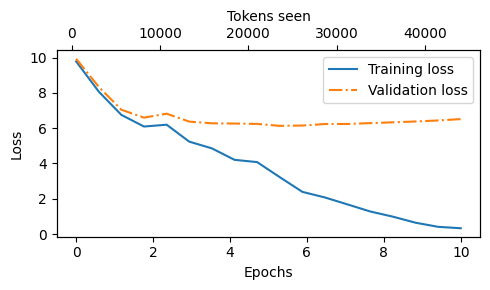

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)